# This script is used to explore flow events.

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 1 Data processing and formating

In [2]:
site = '212058'
freq = 'Daily'
# Process data to format that R package requires for storm event separation.
fn = f'../data/{site}_{freq}.csv'
output_fn = f'../output/{site}_{freq}.csv'
# Read the formated file if it exists.
if os.path.exists(output_fn):
    cq_data = pd.read_csv(output_fn, index_col = 'id')
else: #Generate the formated file if it does not exist.
    cols = ['Discharge (ML/d)', 'Turbidity (NTU)'] # site 212058 does not have rainfall data from the web. 'Rainfall (mm)', 
    cq_data = pd.read_csv(fn, index_col = 'Date and time', skiprows = 3, usecols = [0, 1, 3])
    cq_data.rename(columns={cq_data.columns[ii]: cols[ii] for ii in range(len(cols))}, inplace = True)
    cq_data.index.name = 'Datetime'
    # Process data
    # Drop rows if Turbidity is of value NaN
    cq_data.dropna(axis = 0, how = 'any', inplace = True)
    cq_data.index = pd.to_datetime(cq_data.index, dayfirst = True)
    cq_data.reset_index(inplace=True)
    cq_data['Discharge (cms)'] = round(cq_data['Discharge (ML/d)'] * 1e3 / 86400, 3)
    cq_data.to_csv(f'../output/{site}_{freq}.csv', index_label='id')

## 2. Plots show start of postfire for each catchment.

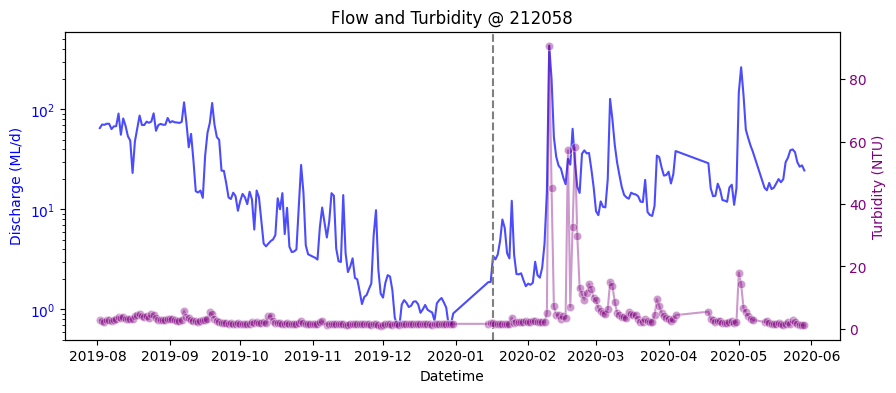

In [5]:
# Set up the figure and axes
plt.figure(figsize=(10, 4))
# convert Datatime column to datetime format
cq_data['Datetime'] = pd.to_datetime(cq_data['Datetime'], format="%d/%m/%Y")
cq_plot = cq_data[(cq_data['Datetime'] < '2020-5-30') & (cq_data['Datetime'] > '2019-8-01')]
cols = cq_plot.columns
# Adding a title
plt.title(f'Flow and Turbidity @ {site}')
# Plot discharge using Seaborn
ax = sns.lineplot(x=cols[0], y=cols[1], data=cq_plot, color='blue', alpha=0.7)
ax.set_ylabel(cols[1], color='blue')
ax.tick_params(axis='y', labelcolor='blue')
ax.set_yscale('log')
# Create a second y-axis for rainfall
ax2 = ax.twinx()

# Plot Turbidity using Seaborn
sns.lineplot(x=cols[0], y=cols[2], data=cq_plot, ax=ax2, color='purple', marker='o', alpha = 0.4)
ax2.set_ylabel(cols[2], color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Add a horizontal line at a specific y-value (for example, y = 5)
ax.axvline(x=pd.to_datetime('2020-01-17'), color='grey', linestyle='--', label='Threshold Line')

# Show the plot
# plt.savefig(f'../output/figs/{site}_{freq}_timeseries.png', bbox_inches = 'tight', dpi=300, format = 'png')